# Machine learning - Features extraction

Runs binary and multi-class classifiers on a given dataset.
Dataset are read as Parquet file. The dataset must contain a feature vector named "features" and a classification column.

## Imports

In [1]:
import pandas as pd
import mltoolkit
from pyspark.sql import SparkSession
import numpy as np
import sklearn

## Configure Spark Session

In [2]:
spark = SparkSession.builder \
                    .master("local[4]") \
                    .appName("datasetClassifier") \
                    .getOrCreate()

## Read in data from parquet file

In [3]:
parquetFile = './input_features/'
data = spark.read.parquet(parquetFile).cache()

df = data.toPandas()
print(f"Total number of data: {df.shape[0]}")
df.head()

Total number of data: 18491


,structureChainId,alpha,beta,coil,foldType,features
0,1LBU.A,0.361502,0.107981,0.530516,other,"[-0.0676212902400502, -0.19547940407580924, 0...."
1,1LC0.A,0.410345,0.275862,0.313793,alpha+beta,"[-0.0792541990609706, 0.040140426752662904, 0...."
2,1LC5.A,0.428169,0.157746,0.414084,alpha+beta,"[-0.019729205948549527, -0.04122427391714465, ..."
3,1LFP.A,0.427984,0.234568,0.337449,alpha+beta,"[-0.19374114630233136, 0.1957719982226169, 0.1..."
4,1LFW.A,0.322650,0.273504,0.403846,alpha+beta,"[-0.29538419953426287, 0.010069241060186297, 0..."


## Select only alpha and beta foldType

In [4]:
df = df[(df.foldType == 'alpha') | (df.foldType == 'beta')]

print(f"Total number of data: {df.shape[0]}")
df.head()

Total number of data: 4937


,structureChainId,alpha,beta,coil,foldType,features
5,1LGH.A,0.857143,0.0,0.142857,alpha,"[-0.26188569416038016, 0.30686419253999536, 0...."
6,1LGH.B,0.744186,0.0,0.255814,alpha,"[-0.10527046018449421, 0.1883829649199139, 0.2..."
7,1LGH.D,0.857143,0.0,0.142857,alpha,"[-0.26188569416038016, 0.30686419253999536, 0...."
8,1LGH.E,0.744186,0.0,0.255814,alpha,"[-0.10527046018449421, 0.1883829649199139, 0.2..."
9,1LGH.G,0.857143,0.0,0.142857,alpha,"[-0.26188569416038016, 0.30686419253999536, 0...."


## Basic dataset information and setting

In [5]:
label = 'foldType'
testFraction = 0.1
seed = 123


vector = df.features.iloc[0]
featureCount = len(vector)
print(f"Feature count    : {featureCount}")

 
classCount = df.foldType.unique().size
print(f"Class count    : {classCount}\n")

  
print(f"Dataset size (unbalanced)    : {df.shape[0]}")
print(df.foldType.value_counts())


df = mltoolkit.downsample(df, 'foldType')
print(f"\nDataset size (balanced)  : {df.shape[0]}")
print(df.foldType.value_counts())

Feature count    : 50
Class count    : 2

Dataset size (unbalanced)    : 4937
alpha    3684
beta     1253
Name: foldType, dtype: int64

Dataset size (balanced)  : 2506
beta     1253
alpha    1253
Name: foldType, dtype: int64


## Random Forest Classifier


 Class	Train	Test

alpha	1138	115

beta	1117	136

Total time taken: 0.233689546585083

Methods	RandomForestClassifier
AUC	0.972378516624041
F Score	0.9402985074626866
Accuracy	0.9362549800796812
Precision	0.9545454545454546
Recall	0.9264705882352942
False Positive Rate	0.045454545454545456
True Positive Rate	0.9159663865546218
	
Confusion Matrix
['alpha' 'beta']
[[109   6]
 [ 10 126]]


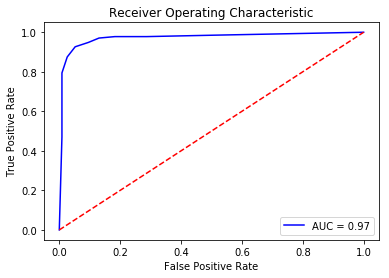

Sample predictions: 


,index,structureChainId,alpha,beta,coil,foldType,features,indexedLabel,predictions
0,16860,5FWH.A,0.000000,0.500000,0.500000,beta,"[0.059506325483417666, -0.09124716649261805, 0...",1,beta
1,13420,2R5Q.C,0.040404,0.545455,0.414141,beta,"[-0.018863669929227656, 0.13303977838356276, 0...",1,beta
2,11314,3OE3.B,0.000000,0.678571,0.321429,beta,"[-0.21789761063325958, -0.4651583757097881, -0...",1,beta
3,2006,5N76.B,0.000000,0.650794,0.349206,beta,"[-0.23624336521785994, 0.09197197252741228, 0....",1,beta
4,6404,1OSV.D,0.666667,0.000000,0.333333,alpha,"[-0.15472791411659934, -0.028848978606137363, ...",0,alpha
5,2000,3GLD.C,0.032258,0.523297,0.444444,beta,"[-0.16564745657133306, -0.00588964515676101, 0...",1,beta
6,9511,1BGF.A,0.790323,0.016129,0.193548,alpha,"[0.22713869498906342, 0.028731578764149817, -0...",0,alpha
7,7074,5T77.A,0.835118,0.000000,0.164882,alpha,"[-0.1495127929462992, 0.05112428734086862, 0.2...",0,beta
8,3029,2O4S.A,0.040404,0.545455,0.414141,beta,"[-0.0022304300979083896, 0.030342101499590338,...",1,beta
9,2978,2IJQ.A,0.634483,0.048276,0.317241,alpha,"[-0.19119134334614502, -0.09284418288152665, 0...",0,beta


In [6]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
mcc = mltoolkit.MultiClassClassifier(clf, 'foldType', testFraction=0.1)
matrics = mcc.fit(df)
for k,v in matrics.items(): print(f"{k}\t{v}")

# Plot ROC 
mltoolkit.plot_roc(mcc.TPR, mcc.FPR, mcc.AUC)    

print("Sample predictions: ")
mcc.prediction.head(10)

## Logistic Regression Classifier


 Class	Train	Test

alpha	1126	127

beta	1129	124

Total time taken: 0.14320135116577148

Methods	LogisticRegression
AUC	0.930975361950724
F Score	0.8906882591093118
Accuracy	0.8924302788844621
Precision	0.8943089430894309
Recall	0.8870967741935484
False Positive Rate	0.10569105691056911
True Positive Rate	0.890625
	
Confusion Matrix
['alpha' 'beta']
[[114  13]
 [ 14 110]]


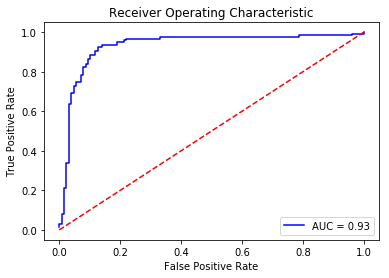

Sample predictions: 


,index,structureChainId,alpha,beta,coil,foldType,features,indexedLabel,predictions
0,8573,4LB2.A,0.714533,0.000000,0.285467,alpha,"[-0.14920335735851414, 0.12474091634575328, 0....",0,alpha
1,8231,3RKC.B,0.020548,0.493151,0.486301,beta,"[-0.06937498296452622, -0.2061433229265975, 0....",1,beta
2,15821,1UJ8.A,0.547945,0.027397,0.424658,alpha,"[-0.4766528715722655, -0.42961276391226993, 0....",0,alpha
3,1736,3TV0.B,0.000000,0.439716,0.560284,beta,"[-0.15739859445647872, -0.029208765061176502, ...",1,beta
4,18459,5TCK.A,0.611511,0.000000,0.388489,alpha,"[-0.24515109326547155, -0.3992543921399957, 0....",0,alpha
5,14721,4X2H.C,0.000000,0.166667,0.833333,beta,"[-0.028663520750246547, 0.0300350989166059, -0...",1,alpha
6,3994,4CE8.B,0.000000,0.622807,0.377193,beta,"[0.0034458712649951995, -0.25041703988624886, ...",1,beta
7,13392,2R19.B,0.042553,0.638298,0.319149,beta,"[0.08163752794690148, 0.03595222216806834, 0.2...",1,beta
8,8987,2CG7.A,0.000000,0.588889,0.411111,beta,"[-0.2815959841180383, -0.036376555167724575, 0...",1,beta
9,8287,3POJ.B,0.000000,0.429825,0.570175,beta,"[-0.20688317910555684, -0.052164533257223006, ...",1,beta


In [7]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
mcc = mltoolkit.MultiClassClassifier(clf, 'foldType', testFraction=0.1)
matrics = mcc.fit(df)
for k,v in matrics.items(): print(f"{k}\t{v}")
    
# Plot ROC 
mltoolkit.plot_roc(mcc.TPR, mcc.FPR, mcc.AUC)
    
print("Sample predictions: ")
mcc.prediction.head(10)

## Simple Multilayer Perception Classifier


 Class	Train	Test

alpha	1132	121

beta	1123	130

Total time taken: 3.232988119125366

Methods	MLPClassifier
AUC	0.952511125238398
F Score	0.9003984063745021
Accuracy	0.900398406374502
Precision	0.9338842975206612
Recall	0.8692307692307693
False Positive Rate	0.06611570247933884
True Positive Rate	0.8692307692307693
	
Confusion Matrix
['alpha' 'beta']
[[113   8]
 [ 17 113]]


/home/marshuang80/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


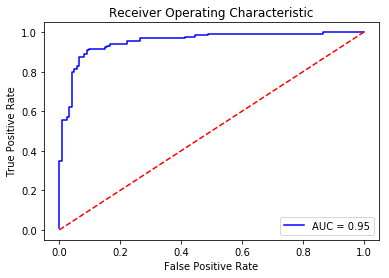

Sample predictions: 


,index,structureChainId,alpha,beta,coil,foldType,features,indexedLabel,predictions
0,13173,1KXG.D,0.000000,0.548611,0.451389,beta,"[-0.11640688738730175, -0.014943559438187554, ...",1,alpha
1,13631,4DT5.A,0.000000,0.685315,0.314685,beta,"[-0.04463111105519282, -0.6677656378597021, 0....",1,beta
2,6824,2QDJ.A,0.702703,0.015444,0.281853,alpha,"[-0.12203431604030503, 0.0415282908568878, 0.0...",0,alpha
3,5680,3BWS.A,0.034398,0.547912,0.417690,beta,"[-0.2245659129629429, 0.03312914014397258, 0.1...",1,beta
4,1215,3GXV.C,0.818182,0.000000,0.181818,alpha,"[0.2544039716234519, 0.36734913715294426, -0.1...",0,alpha
5,6148,5V1Y.F,0.000000,0.166667,0.833333,beta,"[-0.7678434488674005, -0.014793750395377477, 0...",1,beta
6,7793,3HOL.A,0.031683,0.497030,0.471287,beta,"[-0.2195161297783534, 0.02372419662172283, 0.2...",1,beta
7,13515,2RLD.C,0.844828,0.000000,0.155172,alpha,"[0.013394131728758415, 0.04088397955832382, -0...",0,alpha
8,18297,1T08.B,0.760870,0.000000,0.239130,alpha,"[0.07687481946001451, -0.19789877773986922, -0...",0,alpha
9,15640,1MY7.A,0.028037,0.439252,0.532710,beta,"[-0.10310998899384147, 0.003967987324020504, 0...",1,alpha


In [8]:
from sklearn.neural_network import MLPClassifier

layers = [featureCount, 32, 32, classCount]
clf = MLPClassifier(solver='sgd', \
                    alpha=1e-5, \
                    hidden_layer_sizes = (32, 32))
mcc = mltoolkit.MultiClassClassifier(clf, 'foldType', testFraction=0.1)

matrics = mcc.fit(df)
for k,v in matrics.items(): print(f"{k}\t{v}")
    
# Plot ROC 
mltoolkit.plot_roc(mcc.TPR, mcc.FPR, mcc.AUC)
    
print("Sample predictions: ")
mcc.prediction.head(10)

## Terminate Spark

In [9]:
spark.stop()